In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer
import random
import datetime

# Stack over flow tagging

<p style='font-size:20px'><b> 1) Problem description </b></p>
<p>

Stack Overflow is one of the largest, most trusted online community for developers to share & learn their programming knowledge.
The site serves as a platform where users can post questions/discussions on a wide range of topics in computer programming, and other users can answer these queries based on their relevant expertise.
Through active participation, the questions & answers can be voted up or down by other members based on popularity of the discussion.
These questions can be tagged with keywords to attract relevant community to the discussion. e.g the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML

The task of this problem is to identify relevant tags that can be applied to new questions posted based on the ~6M question-tag historical data provided.
    
</p>

<p style='font-size:20px'><b> 2) Dataset description </b></p>
<p>

The Train.csv contains 4 columns: Id, Title, Body, Tags

- Id - Unique identifier for each question
- Title - The question's title
- Body - The body of the question
- Tags - The tags associated with the question (all lowercase, should not contain tabs '\t' or ampersands '&')

There is also a Test.csv file that contains the same columns but without the Tags, which need to be predicted.
    
</p>


<p style='font-size:20px'><b> 3.1) Machine learning problem </b></p>
<p>

- To achieve the task of tag prediction, the goal of the ML model would be to capture any association between the content in the 'Title' & 'Body' features with the corresponding Tags.
- This is a multilabel classification problem meaning that the model output won't be a single value, but rather could be any number of labels.    
    
</p>

<p style='font-size:20px'><b> 3.2) Scoring metric </b></p>
<p>

- There are huge number of unique tags in the dataset, however only a small pareto of tags are frequently occuring accorss many questions.
- Therefore, it is important that the scoring metric gives more importance to the more frequent tags.
- To account for this, the scoring metric would be the Micro-averaged F1 score, which is also the target metric on the Kaggle page.    
    
</p>


<p>

Dataset/problem source link: https://www.kaggle.com/competitions/facebook-recruiting-iii-keyword-extraction

</p>

In [2]:
start_time = datetime.datetime.now()

# Load the Train.csv dataset for Stack over flow tagging problem 
raw_data = pd.read_csv('dataset/Train.csv')

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


Block execution time:  0:08:00.987676


<p style='font-size:16px'><b> 4) Dataset overview </b></p>
<p>

Evaluate basic metrics regarding the data like size, number of features, class values, etc.
    
</p>


In [3]:
start_time = datetime.datetime.now()

# Basic info
print('1. # Rows: ', raw_data.shape[0])
print('2. # Cols: ', raw_data.shape[1])
print('3. Columns: ', raw_data.columns)
print('4. Example dataponts:\n')

for i in range(5):
    datapoint = raw_data.iloc[i]
    print('\n\n----------Datapoint {}-----------------\n'.format(i+1))
    for j in range(4):
        print(raw_data.columns[j], " : ", datapoint[j])

print("\nBlock execution time: ", datetime.datetime.now() - start_time)        

1. # Rows:  6034195
2. # Cols:  4
3. Columns:  Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')
4. Example dataponts:



----------Datapoint 1-----------------

Id  :  1
Title  :  How to check if an uploaded file is an image without mime type?
Body  :  <p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.</p>

<p>Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?</p>

Tags  :  php image-processing file-upload upload mime-types


----------Datapoint 2-----------------

Id  :  2
Title  :  How can I prevent firefox from closing when I press ctrl-w
Body  :  <p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quite often happens to me that firefox is the activ

<p style='font-size:16px'><b> 5.1) Duplicate datapoints </b></p>
<p>

Checking if the dataset has any duplicates and removing them if present.

</p>


In [4]:
# Check for number of duplicte datapoints

start_time = datetime.datetime.now()

duplicates = raw_data[raw_data.duplicated(['Title', 'Body', 'Tags'])]

print("1. Number of duplicate datapoints: ", len(duplicates))
print("2. % of duplicate datapoints: {}%".format(round(100*len(duplicates)/len(raw_data),1)))

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

1. Number of duplicate datapoints:  1827881
2. % of duplicate datapoints: 30.3%

Block execution time:  0:11:29.452784


In [5]:
# drop the duplicate rows and create a new dataset

start_time = datetime.datetime.now()

raw_data = raw_data.drop_duplicates(subset = ['Title', 'Body', 'Tags'])

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


Block execution time:  0:15:12.371165


<p style='font-size:16px'><b> 5.2) Inferences </b></p>
<p>

The dataset is comprised of huge number of duplicate rows (~30% of the total train dataset)

</p>


In [6]:
# Basic info after removing duplicates

start_time = datetime.datetime.now()

print('1. # Rows: ', raw_data.shape[0])
print('2. # Cols: ', raw_data.shape[1])
print('3. Columns: ', raw_data.columns)
print('4. Example dataponts:\n')

for i in range(5):
    datapoint = raw_data.iloc[i]
    print('\n\n----------Datapoint {}-----------------\n'.format(i+1))
    for j in range(4):
        print(raw_data.columns[j], " : ", datapoint[j])
        
print("\nBlock execution time: ", datetime.datetime.now() - start_time)        

1. # Rows:  4206314
2. # Cols:  4
3. Columns:  Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')
4. Example dataponts:



----------Datapoint 1-----------------

Id  :  1
Title  :  How to check if an uploaded file is an image without mime type?
Body  :  <p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.</p>

<p>Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?</p>

Tags  :  php image-processing file-upload upload mime-types


----------Datapoint 2-----------------

Id  :  2
Title  :  How can I prevent firefox from closing when I press ctrl-w
Body  :  <p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quite often happens to me that firefox is the activ

<p style='font-size:16px'><b> 6.1) Title feature </b></p>
<p>

- The title is a short description of the problem that would be later explained in the body.
- It would hold the most relevant & crisp information to draw association with the tag.
- Here, we will look simply at the title lengths in terms of number of words accorss all the questions. This will be done by plotting the histogram of title lengths vs number of questions.

</p>


In [7]:
start_time = datetime.datetime.now()

titles = raw_data.Title
title_lengths = np.array([len(x) for x in titles])

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


Block execution time:  0:00:04.931344


1. Mean length: 50.8
2. Median length: 48.0
3. Standard deviation: 20.1
4. Min length: 9
5. Max length: 219

Block execution time:  0:00:02.955219


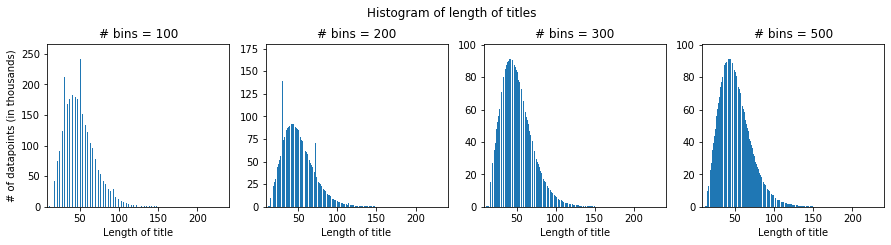

In [8]:
start_time = datetime.datetime.now()

def create_hist(num_bins, axs):
    global title_lengths
    hist, bins = np.histogram(title_lengths, bins = num_bins)
    hist = hist/1000
    axs.bar(bins[:-1], hist)
    x_min = bins[0] - 0.1*abs(bins[0])
    x_max = bins[-1] + 0.1*abs(bins[-1])
    y_min = 0
    y_max = np.max(hist) + 0.1*np.max(hist)
    axs.set_xlim([x_min, x_max])
    axs.set_ylim([y_min, y_max])
    title = '# bins = ' + str(num_bins)
    axs.set(title = title, xlabel = 'Length of title')

# The number of bins is used to decide the bucketing of title lengths
# Histogram: Plot the number of datapoints in each bucket & the title length of corr buckets
num_bins = [100,200,300,500]

# Setting up the figure
fig = plt.figure(figsize = (15,3))
fig.subplots_adjust(wspace = 0.2)
axs = fig.subplots(1, 4)
fig.suptitle('Histogram of length of titles', y = 1.05)
axs[0].set(ylabel = '# of datapoints (in thousands)')

# Plot the histogram for each num_bin values
for i in range(4):
    create_hist(num_bins[i], axs[i])

print("1. Mean length:", round(np.mean(title_lengths),1))
print("2. Median length:", round(np.median(title_lengths),1))
print("3. Standard deviation:", round(np.std(title_lengths),1))
print("4. Min length:", round(np.min(title_lengths),1))
print("5. Max length:", round(np.max(title_lengths),1))

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

<p style='font-size:16px'><b> 6.2) Inferences </b></p>
<p>

- The title lengths follows a right skewed distribution. We can evaluate adding this title length as an independent feature in our problem.

</p>


<p style='font-size:16px'><b> 7) Tag feature </b></p>
<p>

- The tag is the target output of this problem and we will look at various metrics regarding tags in the training data.

</p>


<p style='font-size:14px'><b> 7.1) Number of tags in a datapoint </b></p>
<p>

- Plotting the number of tags present in a datapoint & the corresponding distribution.

</p>


In [9]:
start_time = datetime.datetime.now()

tags = [str(x).split(" ") for x in raw_data.Tags]

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:00:15.139224


Range of number of tags:  [1 2 3 4 5]

Block execution time:  0:00:01.048364


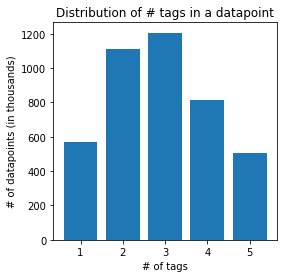

In [10]:
start_time = datetime.datetime.now()

# Distribution of number of tags in the datapoints
num_tags = [len(x) for x in tags]
vals, freq = np.unique(num_tags, return_counts=True)
print("Range of number of tags: ", vals)

# Setting up the figure
fig = plt.figure(figsize = (4,4))
axs = fig.subplots(1, 1)
axs.set(title = 'Distribution of # tags in a datapoint', xlabel = '# of tags', ylabel = '# of datapoints (in thousands)')
axs.bar(vals, freq/1000)

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

<p style='font-size:14px'><b> 7.2) Most common tags </b></p>
<p>

Calculating the 10 most frequent tags in the dataset, with the following metrics for each of the top 10 tags:
- Num of occurences: Number of times/datapoints to which the tag is associated
- % datapoints: Number of datapoints to which the tag is associated as % of total datapoints
- % tagging: Number of occurences of the tag as % of total number of tags accross all datapoints

</p>


In [11]:
start_time = datetime.datetime.now()

# List to store each tagging instance accross all datapoints
tag_list = []

for datapoint in tags:
    for tag in datapoint:
        tag_list.append(tag)

# Calculating the unique tags & their frequency in a descending order from the above tag_list        
unique_tags, tag_count = np.unique(tag_list, return_counts=True)
sort_indices = np.argsort(tag_count)[::-1]
unique_tags = unique_tags[sort_indices]
tag_count = tag_count[sort_indices]

# Calculating the requred info regarding tags
print("1. Number of taggings: ", len(tag_list))
print("2. Number of unique tags: ", unique_tags.shape[0])

# Creating a pandas dataframe of tag info
tag_info = pd.DataFrame()

# Name of the tag
tag_info['Tag name'] = unique_tags

# Absolute number of occurences of the tag accross all datapoints
tag_info['# occurences'] = tag_count

# % of total datapoints having this tag
tag_info['% datapoints'] = np.round(100*tag_count/len(tags),3)

# % of total taggings contributed by this tag
tag_info['% taggings'] = np.round(100*tag_count/len(tag_list),3)

print("3. Top 10 common tag's details: (Pd dataframe output)")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

tag_info.head(10)

1. Number of taggings:  12195954
2. Number of unique tags:  42048
3. Top 10 common tag's details: (Pd dataframe output)

Block execution time:  0:00:15.371192


,Tag name,# occurences,% datapoints,% taggings
0,c#,331505,7.881,2.718
1,java,299414,7.118,2.455
2,php,284103,6.754,2.329
3,javascript,265423,6.310,2.176
4,android,235436,5.597,1.930
5,jquery,221533,5.267,1.816
6,c++,143936,3.422,1.180
7,python,134137,3.189,1.100
8,iphone,128681,3.059,1.055
9,asp.net,125651,2.987,1.030


<p style='font-size:14px'><b> 7.3) Inferences </b></p>
<p>

1. Any datapoint has a maximum of 5 tags, with 2-3 tags being the most common value.
2. 'c#' the most common label is tagged in 7.88% of datapoints & accounts for 2.7% of taggings accross all datapoints.    
3. This affirms that a pareto exists and of the 42k unique tags, certain top % of tags by frequency will account for most of the taggings.

</p>


<p style='font-size:16px'><b> 8.1) Pareto among tags </b></p>
<p>

Calculate the following pareto values by considering various x% of top tags by frequency:
- Num of unique tags
- % of total taggings covered by top tags
- % of datapoints having atleast one of the top tags - partial coverage

Also plot the graph of # occurences vs the tag number in descending order of frequency.
    
</p>




-- Figure number: 1.1 --

Considering top 100% tags:
1. Number of unique tags considered =  42048
2. % of total taggings covered: 100%
3. % of total datapoints covered (partial coverage): 100.0%


-- Figure number: 1.2 --

Considering top 75.0% tags:
1. Number of unique tags considered =  31536
2. % of total taggings covered: 100%
3. % of total datapoints covered (partial coverage): 100.0%


-- Figure number: 1.3 --

Considering top 50.0% tags:
1. Number of unique tags considered =  21024
2. % of total taggings covered: 99%
3. % of total datapoints covered (partial coverage): 99.9%


-- Figure number: 1.4 --

Considering top 25.0% tags:
1. Number of unique tags considered =  10512
2. % of total taggings covered: 96%
3. % of total datapoints covered (partial coverage): 99.6%


-- Figure number: 2.1 --

Considering top 10.0% tags:
1. Number of unique tags considered =  4204
2. % of total taggings covered: 89%
3. % of total datapoints covered (partial coverage): 98.6%


-- Figure number

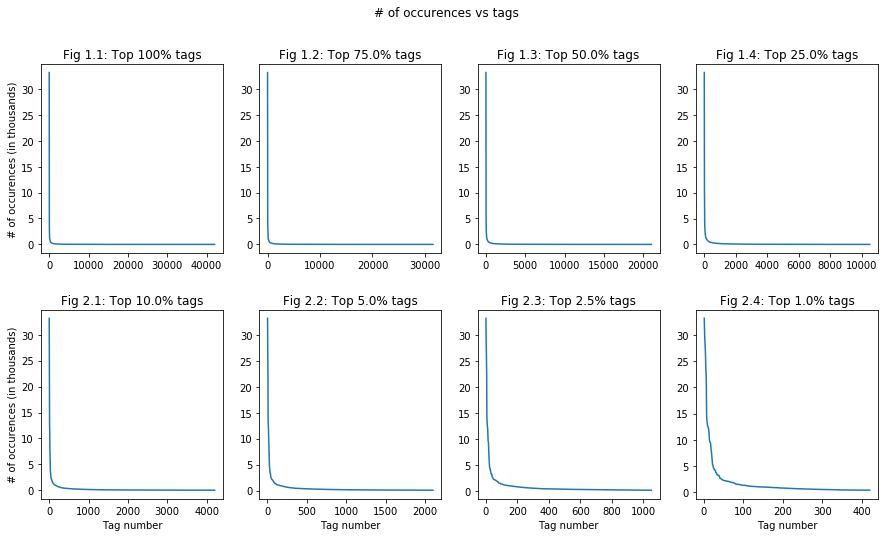

In [12]:
start_time = datetime.datetime.now()

def calc_pareto(axs, percent_tags, fig_num):
    
    global unique_tags, tag_count, ques_tag_map, tag_vocab, total_num_ques
    
    # Defining the fig number corr to which pareto info will be displayed
    print('\033[1m')
    print("\n-- Figure number: {}.{} --".format(fig_num//4+1, fig_num%4+1))
    print('\033[0m')
    
    # % of top tags considered for pareto calculation
    print("Considering top {}% tags:".format(percent_tags*100))
    
    # Absolute number of top tags considered based on above % 
    number_tags = int(len(unique_tags)*percent_tags)
    print("1. Number of unique tags considered = ", number_tags)
    
    # % of total taggings covered by considering the top tags shortlisted above
    print("2. % of total taggings covered: {}%".format(round(100*np.sum(tag_count[:number_tags])/np.sum(tag_count))))
    
    # % of datapoints having atleast one of the top tags shortlisted above
    tag_inds = [tag_vocab[tag] for tag in unique_tags[:number_tags]]
    relev_ques = ques_tag_map[:, tag_inds]
    nonzero_ques = np.unique(relev_ques.nonzero()[0])
    num_ques = len(nonzero_ques)
    print("3. % of total datapoints covered (partial coverage): {}%".format(round(100*num_ques/total_num_ques, 1)))
    
    # Plot the count of occurences vs the tag number for the top tags shortlisted above
    x = np.arange(1,number_tags+1,1)
    y = tag_count[:number_tags]/10000
    axs.plot(x, y)
    title =  'Fig ' + str(fig_num//4+1) + "." + str(fig_num%4+1) + ": " + "Top " + str(percent_tags*100) + "% tags"
    axs.set(title = title)
    if(fig_num%4 == 0):
        axs.set(ylabel = '# of occurences (in thousands)')
    if(fig_num//4 == 1):
        axs.set(xlabel = 'Tag number')

        
# Setting up the plot for # of occurunces vs tag number
fig = plt.figure(figsize = (15,8))
fig.subplots_adjust(wspace = 0.2, hspace = 0.3)
fig.suptitle('# of occurences vs tags')
axs = fig.subplots(2, 4)
percent_tags = [1,0.75,0.5,0.25,0.1,0.05,0.025,0.01]
total_num_ques = raw_data.shape[0]

# Creating a sparse representation of the datapoint/question number and associated tags
cvt = CountVectorizer(analyzer = lambda x:x)
ques_tag_map = cvt.fit_transform(tags)
tag_vocab = cvt.vocabulary_

# Calculate the pareto values considering various number of top % of tags
for i in range(8):
    calc_pareto(axs[i//4, i%4], percent_tags[i], i)
    
print("\n\nBlock execution time: ", datetime.datetime.now() - start_time)

<p style='font-size:16px'><b> 8.2) Inferences </b></p>
<p>

- As expected, there exist a significant pareto in the tags, with around 2100 tags of the 42K unique tags accounting for ~80% taggings.
- Also, the top 420 tags are able to partially cover 88% of datapoints/questions.
- Considering this pareto, and due to computational resource limitations, we will filter the dataset to 1.25lac datapoints & keep only the 500 top tags as the target labels. 

</p>


In [17]:
start_time = datetime.datetime.now()

# Reducing data size for adjusting to PC computational limitations

# Filtering out the datapoints that don't have any of the top 500 tags as the associated tags
top_tags = unique_tags[:500]
tag_inds = [tag_vocab[tag] for tag in top_tags]
relev_ques = ques_tag_map[:, tag_inds]
nonzero_ques = np.unique(relev_ques.nonzero()[0])
temp_data = raw_data.iloc[nonzero_ques]

# Random sampling the data to save 1.5L points which will be later split into train, cv & test data
rand_indices = random.sample(range(0, temp_data.shape[0]), 150000)
trimmed_data = temp_data.iloc[rand_indices]

# Creating a new column name Tags_shortlist that contains only the top 500 tags from the Tags column
tags_temp = [str(x).split(" ") for x in trimmed_data.Tags]
shortlist_tags = [[item for item in datapoint if item in top_tags] for datapoint in tags_temp]
shortlist_tags = [" ".join(item) for item in shortlist_tags]
trimmed_data['Tags_shortlist'] = shortlist_tags

# Removing the old column containing all the tags
trimmed_data.drop(['Tags'], axis = 1, inplace=True)

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


Block execution time:  0:03:40.178248


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
start_time = datetime.datetime.now()

# Save data to csv file
#### Imp: Careful not to overwrite data ###

try:
    trimmed_data.to_csv('dataset/trimmed.csv', mode = 'w', index = False)
except:
    print("File already saved?")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


Block execution time:  0:00:15.153976
